<a href="https://colab.research.google.com/github/lorebianchi98/BrainTumorClassification/blob/main/3_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification using ResNet50
In this notebook we are going to perform the classification of the brain tumor using as base CNN ResNet50.

# Import and Costants

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

# Connection to Google Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
% run /content/gdrive/MyDrive/BrainTumorClassifier/utilities.ipynb

We also perform the download and the unzipping of the dataset from the drive folder.

In [ ]:
!unzip -q '/content/gdrive/MyDrive/BrainTumorClassifier/brain-tumor-mri-splits.zip' -d '/'

# Hardware Accelerator test

First we need to check if the hardware accelaration is enabled, since training a CNN on a CPU could be infeasible.

In [ ]:
#check hardware acceleration
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Dataset loading

Now we need to create the Dataset objects from the sets directory. We use the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function provided by Keras. 

In [ ]:
train_ds, val_ds, test_ds = load_data_splits(IMAGE_SIZE, BATCH_SIZE)

Found 4213 files belonging to 4 classes.
Found 1404 files belonging to 4 classes.
Found 1406 files belonging to 4 classes.


# 256 Dense Neurons
Initially we are going to train a Multilayer Perceptron Network to classify brain tumor having as input the features extracted by ResNet50. The last layer of ResNet50 is removed, since it was a MLP Network built to classify ImageNet Dataset. The Res-Net-50 layers are freezed in this part of training. 

In [ ]:
base_cnn = keras.applications.resnet.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_cnn.trainable = False
base_cnn.summary()

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation_layers(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_cnn(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="ResNet50")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0  

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.7435 - accuracy: 0.7232
Epoch 1: val_loss improved from inf to 0.37820, saving model to model/ResNet50.h5
66/66 [==============================] - 27s 200ms/step - loss: 0.7435 - accuracy: 0.7232 - val_loss: 0.3782 - val_accuracy: 0.8625
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8547
Epoch 2: val_loss improved from 0.37820 to 0.30721, saving model to model/ResNet50.h5
66/66 [==============================] - 12s 174ms/step - loss: 0.3918 - accuracy: 0.8547 - val_loss: 0.3072 - val_accuracy: 0.8853
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8801
Epoch 3: val_loss improved from 0.30721 to 0.25860, saving model to model/ResNet50.h5
66/66 [==============================] - 12s 174ms/step - loss: 0.3199 - accuracy: 0.8801 - val_loss: 0.2586 - val_accuracy: 0.9060
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 

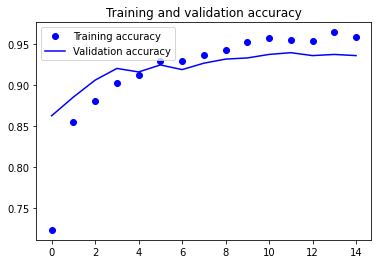

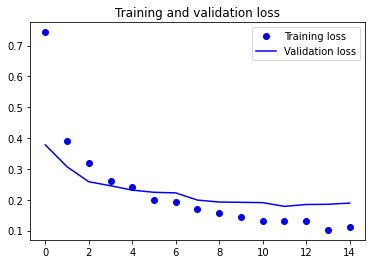

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 4s 141ms/step - loss: 0.2007 - accuracy: 0.9282
Loss on test set: 0.20069462060928345
Accuracy on test set: 0.9281650185585022
              precision    recall  f1-score   support

      glioma     0.9299    0.8985    0.9139       325
  meningioma     0.8347    0.9058    0.8688       329
     notumor     0.9776    0.9800    0.9788       400
   pituitary     0.9671    0.9176    0.9417       352

    accuracy                         0.9282      1406
   macro avg     0.9273    0.9255    0.9258      1406
weighted avg     0.9305    0.9282    0.9288      1406



22/22 [==============================] - 3s 120ms/step


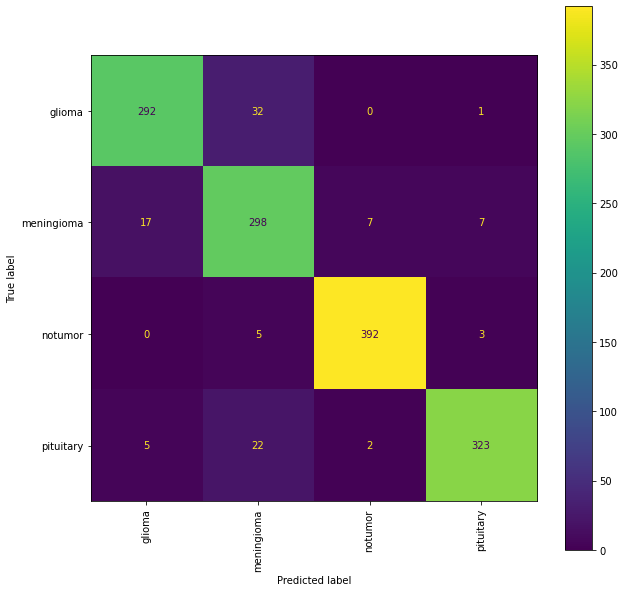

In [ ]:
plot_confusionmatrix(model, test_ds)

# Fine Tuning
Now it is time to unfreeze the last block of ResNet50 to fine tune its weigths on our dataset.

In [ ]:
trainable = False
for layer in model.get_layer("resnet50").layers:
    if layer.name == 'conv5_block3_1_conv':
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0  

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9573
Epoch 1: val_loss improved from inf to 0.19255, saving model to model/ResNet50_Finetuned.h5
66/66 [==============================] - 17s 175ms/step - loss: 0.1171 - accuracy: 0.9573 - val_loss: 0.1926 - val_accuracy: 0.9330
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9599
Epoch 2: val_loss improved from 0.19255 to 0.17657, saving model to model/ResNet50_Finetuned.h5
66/66 [==============================] - 12s 177ms/step - loss: 0.1110 - accuracy: 0.9599 - val_loss: 0.1766 - val_accuracy: 0.9402
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9642
Epoch 3: val_loss improved from 0.17657 to 0.16890, saving model to model/ResNet50_Finetuned.h5
66/66 [==============================] - 12s 177ms/step - loss: 0.1005 - accuracy: 0.9642 - val_loss: 0.1689 - val_accuracy: 0.9387
Epoch 4/50
66/66 [====================

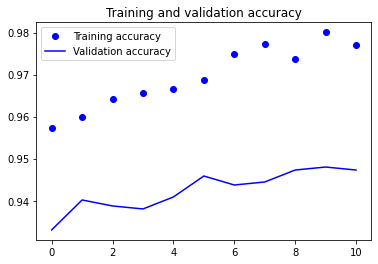

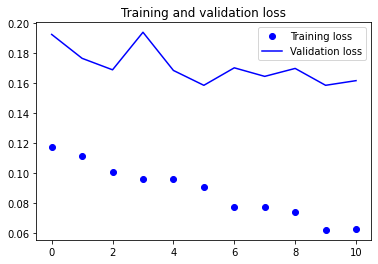

In [ ]:
model, history = run_model(model, model.name + "_Finetuned", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 4s 130ms/step - loss: 0.1802 - accuracy: 0.9438
Loss on test set: 0.18023891746997833
Accuracy on test set: 0.9438122510910034
              precision    recall  f1-score   support

      glioma     0.9215    0.9385    0.9299       325
  meningioma     0.8912    0.8967    0.8939       329
     notumor     0.9825    0.9850    0.9838       400
   pituitary     0.9708    0.9460    0.9583       352

    accuracy                         0.9438      1406
   macro avg     0.9415    0.9415    0.9415      1406
weighted avg     0.9441    0.9438    0.9439      1406



22/22 [==============================] - 3s 123ms/step


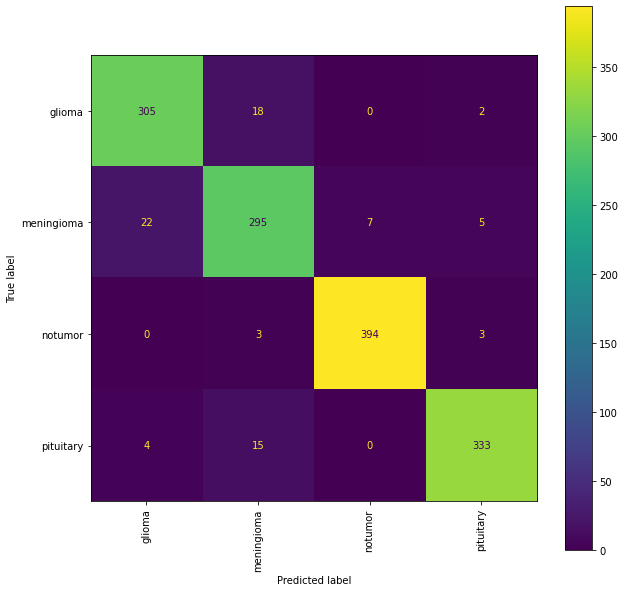

In [ ]:
plot_confusionmatrix(model, test_ds)

# Removing last block
Resnet is trained on ImageNet, which is a dataset very different from ours composed by brain MRI scans. We may hypothesize that the Convolution filters of the last layers of this CNN are prepared to recognise very specific characteristics of the images, while the first filters are used to extract low level features, that are less specific and can relates better to our dataset. 

We try to chop the last block of Resnet-50 before connecting the base CNN to our MLP network and train this MLP network on our dataset with the base freezed. Than we will perform the fine tuning with the last block unfreezed.


In [ ]:
base_cnn = keras.applications.resnet50.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_cnn.trainable = False

In [ ]:
def get_layer_index(model, layer_name):
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index

In [ ]:
model = keras.Model(base_cnn.input, base_cnn.layers[get_layer_index(base_cnn, 'conv4_block6_out')].output, name='base')
model.summary()

Model: "base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                               

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation_layers(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = model(x)
x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="ResNet50_Cutted")
model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "ResNet50_Cutted"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 gap (GlobalAveragePooling2D  (None, 1024)         

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.8484 - accuracy: 0.6701
Epoch 1: val_loss improved from inf to 0.49300, saving model to model/ResNet50_Cutted.h5
66/66 [==============================] - 16s 185ms/step - loss: 0.8484 - accuracy: 0.6701 - val_loss: 0.4930 - val_accuracy: 0.8419
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.8213
Epoch 2: val_loss improved from 0.49300 to 0.40534, saving model to model/ResNet50_Cutted.h5
66/66 [==============================] - 12s 163ms/step - loss: 0.5029 - accuracy: 0.8213 - val_loss: 0.4053 - val_accuracy: 0.8654
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.8436
Epoch 3: val_loss improved from 0.40534 to 0.34978, saving model to model/ResNet50_Cutted.h5
66/66 [==============================] - 12s 162ms/step - loss: 0.4190 - accuracy: 0.8436 - val_loss: 0.3498 - val_accuracy: 0.8853
Epoch 4/50
66/66 [=============================

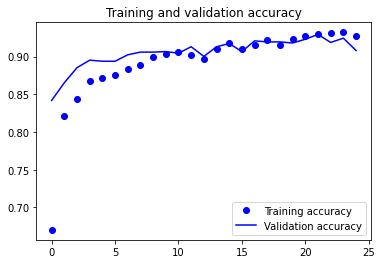

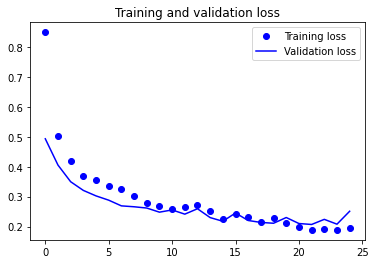

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 4s 116ms/step - loss: 0.2130 - accuracy: 0.9211
Loss on test set: 0.21303817629814148
Accuracy on test set: 0.9210526347160339
              precision    recall  f1-score   support

      glioma     0.9359    0.8985    0.9168       325
  meningioma     0.8416    0.8723    0.8567       329
     notumor     0.9673    0.9600    0.9636       400
   pituitary     0.9326    0.9432    0.9379       352

    accuracy                         0.9211      1406
   macro avg     0.9193    0.9185    0.9187      1406
weighted avg     0.9219    0.9211    0.9213      1406



22/22 [==============================] - 3s 117ms/step


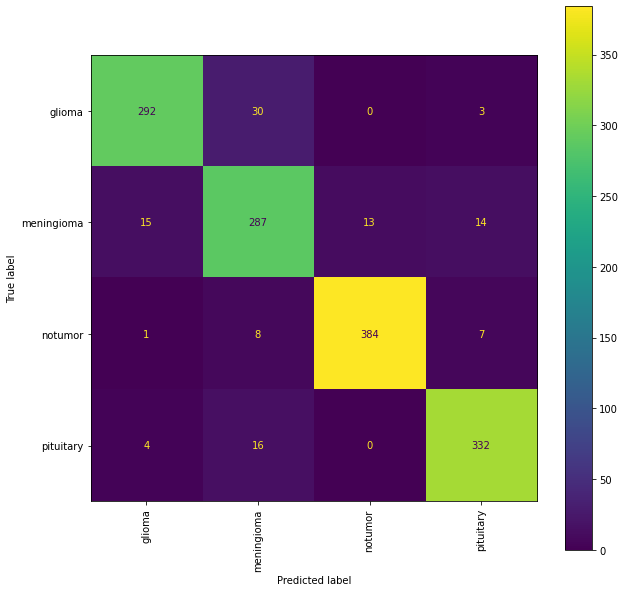

In [ ]:
plot_confusionmatrix(model, test_ds)

## Fine Tuning chopped model
Now it is time to unfreeze the last block of ResNet50 to fine tune its weigths on our dataset.

In [ ]:
model.get_layer("base").summary()

Model: "base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                               

In [ ]:
trainable = False
for layer in model.get_layer("base").layers:
    if layer.name == 'conv4_block6_1_conv':
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable


Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9276
Epoch 1: val_loss improved from inf to 0.21701, saving model to model/ResNet50_Cutted_Finetuned.h5
66/66 [==============================] - 15s 162ms/step - loss: 0.2065 - accuracy: 0.9276 - val_loss: 0.2170 - val_accuracy: 0.9266
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9283
Epoch 2: val_loss improved from 0.21701 to 0.21381, saving model to model/ResNet50_Cutted_Finetuned.h5
66/66 [==============================] - 11s 160ms/step - loss: 0.1979 - accuracy: 0.9283 - val_loss: 0.2138 - val_accuracy: 0.9174
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9278
Epoch 3: val_loss improved from 0.21381 to 0.19584, saving model to model/ResNet50_Cutted_Finetuned.h5
66/66 [==============================] - 11s 163ms/step - loss: 0.2000 - accuracy: 0.9278 - val_loss: 0.1958 - val_accuracy: 0.9302
Epoch 4/50
66/66 

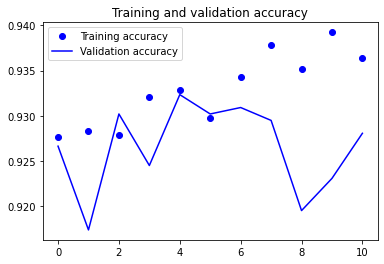

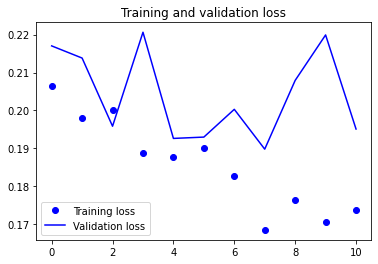

In [ ]:
model, history = run_model(model, model.name + "_Finetuned", train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 4s 116ms/step - loss: 0.2038 - accuracy: 0.9225
Loss on test set: 0.20377576351165771
Accuracy on test set: 0.9224750995635986
              precision    recall  f1-score   support

      glioma     0.9088    0.9200    0.9144       325
  meningioma     0.8616    0.8328    0.8470       329
     notumor     0.9564    0.9875    0.9717       400
   pituitary     0.9509    0.9347    0.9427       352

    accuracy                         0.9225      1406
   macro avg     0.9194    0.9187    0.9189      1406
weighted avg     0.9218    0.9225    0.9220      1406



22/22 [==============================] - 2s 113ms/step


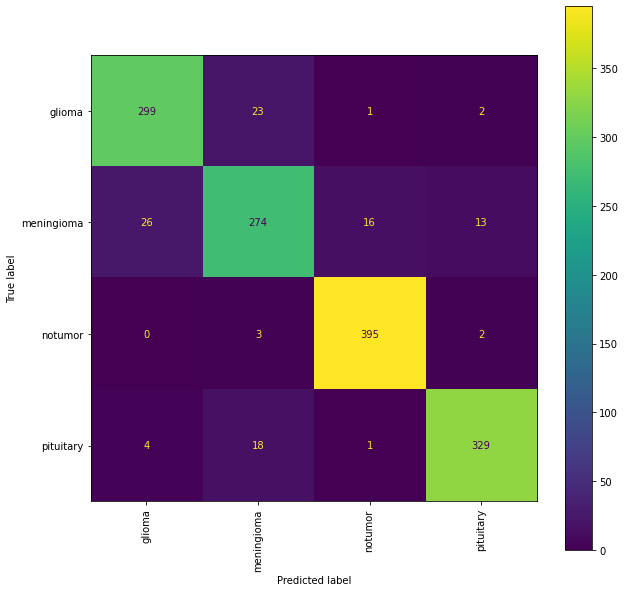

In [ ]:
plot_confusionmatrix(model, test_ds)